# NAMED ENTITY RECOGNITION CLASSIFICATION


### Import necessary modules

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.chunk import tree2conlltags
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

### Data prepping

In [ ]:
# Step 1: Load the CSV file
df = pd.read_csv('/meghan_tweets.csv', encoding='utf-8')

# Remove duplicate tweets directly in the DataFrame
df_unique = df.drop_duplicates(subset='Tweet')

# You can optionally reset the index if you want a continuous index after dropping duplicates
df_unique = df_unique.reset_index(drop=True)


# Step 2: Extract the 'Tweet' column
tweets = df['Tweet'].tolist()

# Load the set of English stopwords
stop_words = set(stopwords.words('english'))

def process_tweet(tweet):
    # Tokenize the tweet
    tokens = word_tokenize(tweet)

    # Apply POS tagging
    pos_tags = pos_tag(tokens)

    # Parse named entities using a chunk parser
    named_entities = ne_chunk(pos_tags)

    # Convert the tree to IOB tags (token, pos, iob_ne)
    iob_tagged = tree2conlltags(named_entities)

    # Skip stopwords
    iob_tagged_nonstop = [(word, pos, iob) for word, pos, iob in iob_tagged if word.lower() not in stop_words]

    return iob_tagged_nonstop

### Problem: Class Imbalance
As we can observe, we have a greater number of entities labeled as O (like 1071544) with respect to other entities. This causes the model to learn to predict 'O' most of the time because it's the dominant class.

### Solution: Class Balancing

In [ ]:
# Define a threshold for maximum proportion of 'O' class labels allowed in a tweet
O_CLASS_THRESHOLD = 0.5  # e.g., no more than 50% of tokens may be 'O'

# Initialize lists to hold features and labels for training
training_features = []
training_gold_labels = []

# Process each tweet
for tweet in tweets:
    # Process each tweet to get (word, pos, ne_label) tuples
    processed_tweet = process_tweet(tweet)

    # Calculate the proportion of 'O' class labels in the processed tweet
    o_label_count = sum(1 for _, _, ne_label in processed_tweet if ne_label == 'O')
    o_label_proportion = o_label_count / len(processed_tweet)

    # Only proceed if the proportion of 'O' class labels is below the threshold
    if o_label_proportion <= O_CLASS_THRESHOLD:
        # For each token in the processed tweet, extract features and NE labels
        for token, pos, ne_label in processed_tweet:
            # Create a feature dictionary for each token
            a_dict = {
                'words': token,
                'pos': pos,
            }
            # Append the feature dictionary and NE label to the respective lists
            training_features.append(a_dict)
            training_gold_labels.append(ne_label)

In [ ]:
from collections import Counter

# Calculate the number of instances in train set
num_train_instances = len(training_features)

# Generate frequency distribution of NERC labels in train
train_label_freq = Counter(training_gold_labels)

# Print the number of instances in train
print("Number of instances in train:", num_train_instances)
print()

# Print frequency distribution of NERC labels in train dataset
print("NERC label frequency in train dataset:")
for label, freq in train_label_freq.items():
    print(f"{label}: {freq}")

Number of instances in train: 5920

NERC label frequency in train dataset:
O: 2699
B-ORGANIZATION: 1057
I-ORGANIZATION: 341
B-PERSON: 849
I-PERSON: 720
B-GPE: 222
B-FACILITY: 11
I-FACILITY: 11
B-GSP: 3
I-GPE: 7


### Test Set

In [ ]:
import pandas as pd

# Load the TSV file into a DataFrame
df_test = pd.read_csv('NER-test.tsv', delimiter='\t', header=None, names=['words', 'pos', 'ignore', 'chunk'])

# Since the DataFrame df_test already contains the words, POS tags, and chunk labels,
# you can directly use it to create features and gold labels for the test set.
test_features = []
test_gold_labels = []

# Iterate over each row in the DataFrame, skipping stopwords
for index, row in df_test.iterrows():
    # Check if the word is not a stopword
    if row['words'].lower() not in stop_words:
        # Create a feature dictionary for each token that is not a stopword
        a_dict = {
            'words': row['words'],
            'pos': row['pos'],
        }
        # Append the feature dictionary to the test features
        test_features.append(a_dict)

        # Append the chunk label to the test gold labels
        test_gold_labels.append(row['chunk'])

Test Features:
{'words': 'sentence id', 'pos': 'token id'}
{'words': '0', 'pos': '0'}
{'words': '0', 'pos': '1'}
{'words': '0', 'pos': '2'}
{'words': '0', 'pos': '3'}
{'words': '0', 'pos': '4'}
{'words': '0', 'pos': '5'}
{'words': '0', 'pos': '6'}
{'words': '0', 'pos': '7'}
{'words': '0', 'pos': '8'}
{'words': '0', 'pos': '9'}
{'words': '0', 'pos': '10'}
{'words': '0', 'pos': '11'}
{'words': '0', 'pos': '12'}
{'words': '0', 'pos': '13'}
{'words': '0', 'pos': '14'}
{'words': '0', 'pos': '15'}
{'words': '0', 'pos': '16'}
{'words': '1', 'pos': '0'}
{'words': '1', 'pos': '1'}

Test Gold Labels:
BIO NER tag
O
O
O
O
O
O
O
O
B-ORG
O
O
O
O
O
B-PERSON
I-PERSON
O
B-PERSON
I-PERSON


In [ ]:
from collections import Counter

# Calculate the number of instances in test
num_test_instances = len(test_features)

# Generate frequency distribution of NERC labels in test datasets
test_label_freq = Counter(test_gold_labels)

# Print the number of instances in test datasets
print("Number of instances in test:", num_test_instances)
print()


# Print frequency distribution of NERC labels in test dataset
print("\nNERC label frequency in test dataset:")
for label, freq in test_label_freq.items():
    print(f"{label}: {freq}")


Number of instances in test: 194


NERC label frequency in test dataset:
BIO NER tag: 1
O: 160
B-ORG: 3
B-PERSON: 3
I-PERSON: 2
I-ORG: 6
B-WORK_OF_ART: 4
I-WORK_OF_ART: 9
B-PER: 3
B-DATE: 1
I-DATE: 1
I-PER: 1


### NERC Task with SVM

In [ ]:
from sklearn.feature_extraction import DictVectorizer


# Concatenate train and test features into one list
all_features = training_features + test_features

# Load the concatenated list of dictionaries
vectorizer = DictVectorizer()
all_features_vectorized = vectorizer.fit_transform(all_features)

# Split back into training and test sets using an index
num_train_instances = len(training_features)
train_features_vectorized = all_features_vectorized[:num_train_instances]
test_features_vectorized = all_features_vectorized[num_train_instances:]

# Print the shape of the training and test feature vectors
print("Shape of training feature vector:", train_features_vectorized.shape)
print("Shape of test feature vector:", test_features_vectorized.shape)


NameError: name 'training_features' is not defined

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report


In [ ]:
# Initialize the SVM classifier with balanced class weights
lin_clf = svm.LinearSVC()

# Fit the model on the training data
lin_clf.fit(train_features_vectorized, training_gold_labels)

# Predict the labels on the test data
test_predictions = lin_clf.predict(test_features_vectorized)

# Generate a classification report
report = classification_report(test_gold_labels, test_predictions)

print(report)

               precision    recall  f1-score   support

       B-DATE       0.00      0.00      0.00         1
        B-ORG       0.00      0.00      0.00         3
        B-PER       0.00      0.00      0.00         3
     B-PERSON       0.00      0.00      0.00         3
B-WORK_OF_ART       0.00      0.00      0.00         4
  BIO NER tag       0.00      0.00      0.00         1
       I-DATE       0.00      0.00      0.00         1
        I-ORG       0.00      0.00      0.00         6
        I-PER       0.00      0.00      0.00         1
     I-PERSON       0.00      0.00      0.00         2
I-WORK_OF_ART       0.00      0.00      0.00         9
            O       0.82      1.00      0.90       160

     accuracy                           0.82       194
    macro avg       0.07      0.08      0.08       194
 weighted avg       0.68      0.82      0.75       194



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The imbalance in the test set could be leading the model to predict 'O' for almost all instances because this is statistically the most successful prediction. A model's performance is not only a function of the quality of training but also the quality of the test data on which it is evaluated. If the test data is not representative of the true data distribution or lacks sufficient examples of certain classes, the model will not be able to demonstrate its true predictive power for those classes.



### Check How Our Model Performs

Since the test set provided appears to be imbalanced, we decided to check how our model performs we decided to split it into training and test sets (with a 80:20 proportion).

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('meghan_tweets.csv')

# Remove duplicate tweets directly in the DataFrame
df_unique = df.drop_duplicates(subset='Tweet')

# You can optionally reset the index if you want a continuous index after dropping duplicates
df_unique = df_unique.reset_index(drop=True)

# Step 2: Extract the 'Tweet' column
tweets = df['Tweet'].tolist()

# Load the set of English stopwords
stop_words = set(stopwords.words('english'))

# Define the function for processing tweets
def process_tweet(tweet):
    # Tokenize, POS tag, NER chunk, and IOB tag
    tokens = word_tokenize(tweet)
    pos_tags = pos_tag(tokens)
    ne_chunks = ne_chunk(pos_tags)
    iob_tagged = tree2conlltags(ne_chunks)
    return iob_tagged

# Define a threshold for maximum proportion of 'O' class labels allowed in a tweet
O_CLASS_THRESHOLD = 0.5

# Initialize lists to hold all processed features and labels
all_features = []
all_labels = []

# Process each tweet and create a list of features and labels
for tweet in tweets:
    processed_tweet = process_tweet(tweet)

    o_label_count = sum(1 for _, _, label in processed_tweet if label == 'O')
    o_label_proportion = o_label_count / len(processed_tweet)

    if o_label_proportion <= O_CLASS_THRESHOLD:
        for token, pos, ne_label in processed_tweet:
            all_features.append({'words': token, 'pos': pos})
            all_labels.append(ne_label)

# Split the processed features and labels into training and test sets (80:20 split)
features_train, features_test, labels_train, labels_test = train_test_split(
    all_features, all_labels, test_size=0.20, random_state=42
)


In [ ]:
from collections import Counter

# Calculate the number of instances in train set
num_train_instances = len(features_train)

# Generate frequency distribution of NERC labels in train
train_label_freq = Counter(labels_train)

# Print the number of instances in train
print("Number of instances in train:", num_train_instances)
print()

# Print frequency distribution of NERC labels in train dataset
print("NERC label frequency in train dataset:")
for label, freq in train_label_freq.items():
    print(f"{label}: {freq}")
print()

# Calculate the number of instances in test
num_test_instances = len(features_test)

# Generate frequency distribution of NERC labels in test datasets
test_label_freq = Counter(labels_test)

# Print the number of instances in test datasets
print("Number of instances in test:", num_test_instances)
# Print frequency distribution of NERC labels in test dataset
print("\nNERC label frequency in test dataset:")
for label, freq in test_label_freq.items():
    print(f"{label}: {freq}")

Number of instances in train: 2032

NERC label frequency in train dataset:
O: 923
I-PERSON: 327
B-GPE: 62
B-PERSON: 271
B-ORGANIZATION: 277
I-ORGANIZATION: 165
B-GSP: 1
I-FACILITY: 3
I-GPE: 2
B-FACILITY: 1

Number of instances in test: 508

NERC label frequency in test dataset:
B-PERSON: 58
I-PERSON: 85
O: 241
B-GPE: 7
B-ORGANIZATION: 63
I-ORGANIZATION: 49
I-FACILITY: 2
B-GSP: 1
B-FACILITY: 1
I-GPE: 1


In [ ]:
from sklearn.feature_extraction import DictVectorizer

# Concatenate train and test features into one list
all_features = features_train + features_test

# Load the concatenated list of dictionaries
vectorizer = DictVectorizer()
all_features_vectorized = vectorizer.fit_transform(all_features)

# Split back into training and test sets using an index
num_train_instances = len(features_train)
train_features_vectorized = all_features_vectorized[:num_train_instances]
test_features_vectorized = all_features_vectorized[num_train_instances:]

# Print the shape of the training and test feature vectors
print("Shape of training feature vector:", train_features_vectorized.shape)
print("Shape of test feature vector:", test_features_vectorized.shape)

Shape of training feature vector: (2032, 894)
Shape of test feature vector: (508, 894)


In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report

# Initialize the SVM classifier with balanced class weights
lin_clf = svm.LinearSVC()

# Fit the model on the training data
lin_clf.fit(train_features_vectorized, labels_train)

# Predict the labels on the test data
test_predictions = lin_clf.predict(test_features_vectorized)

# Generate a classification report
report = classification_report(labels_test, test_predictions)

print(report)

                precision    recall  f1-score   support

    B-FACILITY       0.00      0.00      0.00         1
         B-GPE       0.44      0.57      0.50         7
         B-GSP       0.00      0.00      0.00         1
B-ORGANIZATION       0.97      0.59      0.73        63
      B-PERSON       0.53      0.45      0.49        58
    I-FACILITY       0.00      0.00      0.00         2
         I-GPE       0.00      0.00      0.00         1
I-ORGANIZATION       0.35      0.16      0.22        49
      I-PERSON       0.39      0.76      0.52        85
             O       0.94      0.87      0.91       241

      accuracy                           0.69       508
     macro avg       0.36      0.34      0.34       508
  weighted avg       0.73      0.69      0.69       508



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Our Report splitting our dataset into training and test set:**

Had higher precision for specific classes like B-ORG, B-PERSON, and I-PERSON.
Showed some ability to identify a wider range of entity types beyond just the 'O' class.
Exhibited lower overall accuracy (0.69 compared to 0.82).
The macro average scores were higher (around 0.34 compared to 0.07), indicating a slightly better balance across different classes.
The weighted average scores took into account the support for each class, resulting in higher averages due to the 'O' class's dominance.

**Report for our dataset for training and given (imbalanced) dataset**

Shows zero precision, recall, and F1-score for all named entity classes except the 'O' class.
The 'O' class has very high precision, recall, and F1-scores, indicating the model almost exclusively predicts the 'O' class.
Exhibited higher overall accuracy (0.82), but this is likely due to the model's bias toward predicting the 'O' class, which is the most frequent.
Both macro and weighted average scores are significantly lower, suggesting that the model is less capable of identifying entities across the board.

# SENTIMENT ANALYSIS

### Vader

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Load the CSV file into a DataFrame
df = pd.read_csv('meghan_tweets.csv')

# Initialize VADER's SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a list to store tweet information and sentiment
tweets_sentiment = []

# Add sentiment scores to the DataFrame and store results in the list
for index, row in df.iterrows():
    sentiment_score = sia.polarity_scores(row["Tweet"])['compound']
    tweet_info = {
        "text": row["Tweet"],
        "sentiment_score": sentiment_score
    }
    tweets_sentiment.append(tweet_info)


# Accessing the first tweet's information as an example
first_tweet_info = tweets_sentiment[0]
print(first_tweet_info['text'])  # This will print the text of the first tweet
print(first_tweet_info['sentiment_score'])  # This will print the sentiment score of the first tweet

@RoyalFamily @ClarenceHouse @KensingtonRoyal
 "we are very much not a racist family" said #PrinceWilliam… https://t.co/eovEe8h92H
0.5398


In [ ]:
def vader_output_to_label(vader_output):
    """
    map vader output e.g.,
    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
    to one of the following values:
    a) positive float -> 'positive'
    b) 0.0 -> 'neutral'
    c) negative float -> 'negative'

    :param dict vader_output: output dict from vader

    :rtype: str
    :return: 'negative' | 'neutral' | 'positive'
    """
    compound = vader_output['compound']

    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    elif compound > 0.0:
        return 'positive'

assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0}) == 'neutral'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.01}) == 'positive'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': -0.01}) == 'negative'

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
mytweets = []
all_vader_output = []
gold = []

analyzer = SentimentIntensityAnalyzer()

# settings (to change for different experiments)
to_lemmatize = True
pos = set()

for tweet in tweets_sentiment:
    the_tweet = tweet['text']
    vader_output = analyzer.polarity_scores(the_tweet)
    vader_label = vader_output_to_label(vader_output)# convert vader output to category

    mytweets.append(the_tweet)
    all_vader_output.append(vader_label)
    gold.append(tweet['sentiment_score'])




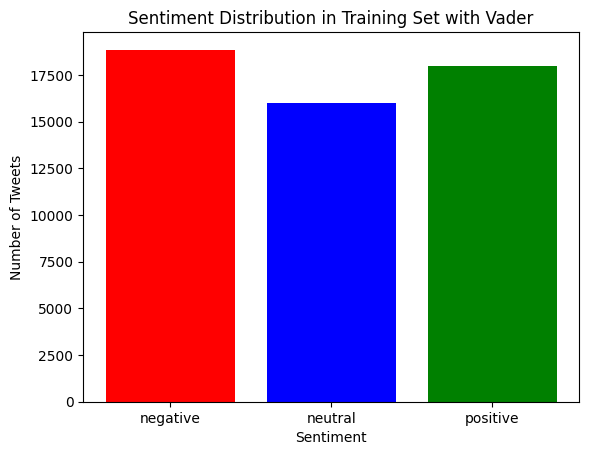

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of occurrences for each sentiment label
sentiment_counts = Counter(all_vader_output)

# Sort the keys so the order is the same every time we run this
sorted_keys = sorted(sentiment_counts.keys())

# Colors for the bars
colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}

# Plotting the bar graph
plt.bar(sorted_keys, [sentiment_counts[k] for k in sorted_keys], color=[colors[k] for k in sorted_keys])
plt.title('Sentiment Distribution in Training Set with Vader')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Keep the sentiment labels horizontal for clarity
plt.show()




### Sentiment Analysis on Test set (provided) using our data sentiment labels for prediction

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Load your training data
df_test = pd.read_csv('sentiment-topic-test.tsv', delimiter='\t')

# Create a machine learning pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB()),
])


# Train the model
pipeline.fit(mytweets, all_vader_output)

X_test = df_test['text']  # Update with your actual text column name

# Predict the sentiment for the new test data
df_test['predicted_sentiment'] = pipeline.predict(X_test)

# Optionally, display the classification report
print(classification_report(df_test['sentiment'], df_test['predicted_sentiment'], target_names=['negative', 'neutral', 'positive']))

# Save the predictions to a new CSV file
df_test.to_csv('predicted_sentiment.csv', index=False)

              precision    recall  f1-score   support

    negative       0.25      0.25      0.25         4
     neutral       0.00      0.00      0.00         3
    positive       0.33      0.67      0.44         3

    accuracy                           0.30        10
   macro avg       0.19      0.31      0.23        10
weighted avg       0.20      0.30      0.23        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


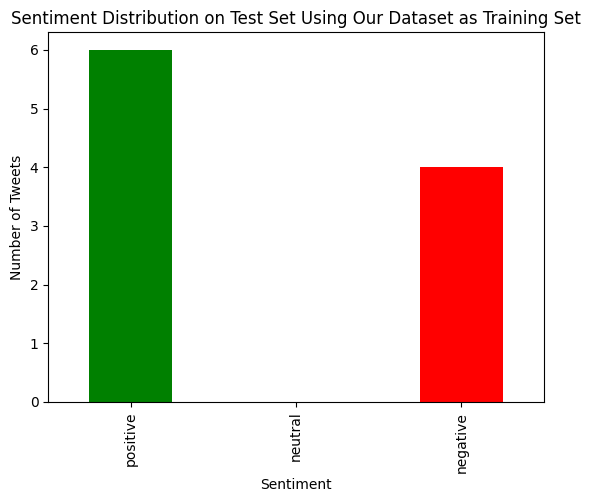

In [ ]:
# Plot the bar graph for predicted sentiment distribution
predicted_sentiment_counts = df_test['predicted_sentiment'].value_counts()
predicted_sentiment_counts = predicted_sentiment_counts.reindex(['positive', 'neutral', 'negative'])
predicted_sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution on Test Set Using Our Dataset as Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

### TextBlob

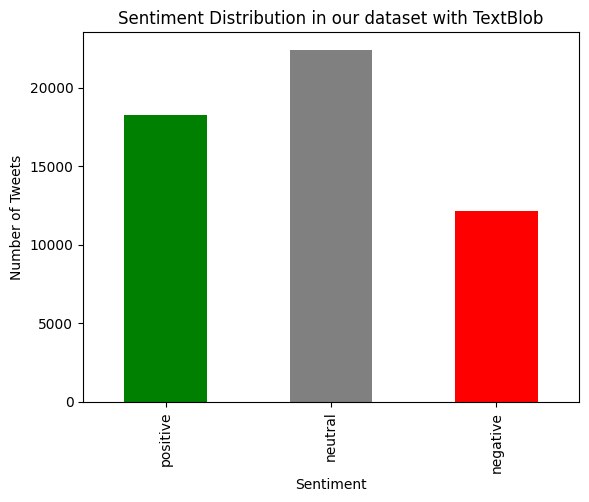

In [ ]:
from textblob import TextBlob
import pandas as pd

# Function to perform sentiment analysis using TextBlob
def perform_sentiment_analysis(sentence):
    # Determine the sentiment using TextBlob
    sentiment_score = TextBlob(sentence).sentiment.polarity
    sentiment = "positive" if sentiment_score > 0 else "negative" if sentiment_score < 0 else "neutral"
    return sentiment

# Load your CSV data
df = pd.read_csv('meghan_tweets.csv')

# Assuming the text to analyze is in a column named 'text'
# Apply the sentiment analysis function to the 'text' column
df['sentiment'] = df['Tweet'].apply(perform_sentiment_analysis)

# This DataFrame now includes the sentiment analysis
# Create a new variable to store the DataFrame with the sentiment column
df_with_sentiment = df

# use df_with_sentiment for further processing or analysis
# save the DataFrame with the new 'sentiment' column to a CSV file
df_with_sentiment.to_csv('meghan_tweets_with_sentiment.csv', index=False)


import matplotlib.pyplot as plt

sentiment_counts = df_with_sentiment['sentiment'].value_counts()

# Sort the index to maintain the order of sentiment types if needed
sentiment_counts = sentiment_counts.reindex(["positive", "neutral", "negative"])

# Create a bar plot, with colors specified for each sentiment type
colors = ['green', 'gray', 'red']  # Example colors for positive, neutral, and negative
sentiment_counts.plot(kind='bar', color=colors)

# Set the title and labels
plt.title('Sentiment Distribution in our dataset with TextBlob')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# Show the plot
plt.show()


### Test Set

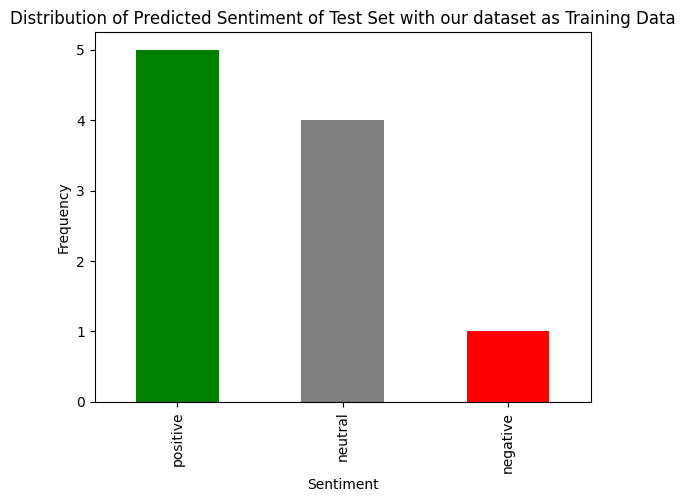

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load your training data
train_df = pd.read_csv('meghan_tweets_with_sentiment.csv')

# Sample a fraction of the training data, for example, 10%
train_df_sampled = train_df.sample(frac=0.1, random_state=42)

X_train = train_df_sampled['Tweet']
y_train = train_df_sampled['sentiment']

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Prepare the test set
test_df = pd.read_csv('sentiment-topic-test.tsv', delimiter='\t')

X_test = test_df['text']
X_test_tfidf = vectorizer.transform(X_test)

# Predict sentiment on the test set
test_df['predicted_sentiment'] = svm_classifier.predict(X_test_tfidf)

# Plot the bar graph for predicted sentiment distribution
predicted_sentiment_counts = test_df['predicted_sentiment'].value_counts()
predicted_sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Distribution of Predicted Sentiment of Test Set with our dataset as Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Since we have true labels in our test set, we can calculate the classification report
true_labels = test_df['sentiment']
print(classification_report(true_labels, test_df['predicted_sentiment']))

              precision    recall  f1-score   support

    negative       1.00      0.25      0.40         4
     neutral       0.50      0.67      0.57         3
    positive       0.40      0.67      0.50         3

    accuracy                           0.50        10
   macro avg       0.63      0.53      0.49        10
weighted avg       0.67      0.50      0.48        10



# TOPIC CLASSIFICATION

### LDA

In [ ]:
import pandas as pd
import nltk
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.chunk import tree2conlltags
from sklearn.model_selection import train_test_split
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [ ]:
#lda model on tweets data

# Load data from CSV
df = pd.read_csv("/meghan_tweets.csv")

# Preprocess the tweets
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Apply preprocessing to tweets
df['Processed_Tweets'] = df['Tweet'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = Dictionary(df['Processed_Tweets'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
#dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in df['Processed_Tweets']]

# Train the LDA model
num_topics = 3  # Adjust the number of topics as needed
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# Initialize lists for topics and probabilities
topics = []
probabilities = []
threshold = 0.5  # Adjust the threshold as needed

# Iterate over the DataFrame
for index, row in df.iterrows():
    processed_tweet = row['Processed_Tweets']
    if not processed_tweet:
        topics.append(None)
        probabilities.append(None)
        #print(f"Skipping row {index} due to empty processed tweet")
        continue

    tweet_bow = dictionary.doc2bow(processed_tweet)
    if not tweet_bow:
        topics.append(None)
        probabilities.append(None)
        #print(f"Skipping row {index} due to invalid bag-of-words representation")
        continue

    # Extract the dominant topic and its probability
    topic_distribution = lda_model.get_document_topics(tweet_bow)
    dominant_topic, prob = max(topic_distribution, key=lambda x: x[1])
    if prob >= threshold:
        topics.append(dominant_topic)
        probabilities.append(prob)
    else:
        topics.append(None)
        probabilities.append(None)

# Assign topics and probabilities to DataFrame
df['Topic'] = topics
df['Topic_Probability'] = probabilities

# Get the top words for each topic
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=1, formatted=False)

# Define topic labels based on top words
topic_labels = {i: ', '.join([word[0] for word in words]) for i, words in topic_words}

# Print the tweets along with their corresponding topics and probabilities
for index, row in df.head(30).iterrows():
    if row['Topic'] != 'Unknown' and not pd.isnull(row['Topic_Probability']):
        tweet_text = row['Tweet']
        topic_label = topic_labels.get(row['Topic'], 'Unknown') if not pd.isnull(row['Topic']) else 'Unknown'
        probability = f"{row['Topic_Probability']:.4f}" if not pd.isnull(row['Topic_Probability']) else 'N/A'
        print(f"Tweet: {tweet_text}")
        print(f"Topic: {topic_label} (Probability: {probability})")
        print()

Tweet: Listen to my latest podcast episode, entitled "AVIOT - S2 - Episode 21 - The case of Meghan Markle (Feat. Toya)". ⚓… https://t.co/YxYBvdQljP
Topic: meghanmarkle (Probability: 0.8669)

Tweet: #MeghanMarkle is salty AF 'cause her #moonbump, 'Archie' didn't get a (racist) royal title.  So... since 'Archie' c… https://t.co/RXTgHayNkr
Topic: https (Probability: 0.9331)

Tweet: #meghanmarkle didn’t know anything about the BRF
#meghanmarkleisaliarandabully #meghanmarklecansuckspotteddicks https://t.co/tHX8V9edXs
Topic: https (Probability: 0.8937)

Tweet: #RoyalFamily 
#MeghanandHarryonOprah 
#OprahMeghanHarry 
#MeghanMarkle 
#MeghanAndHarry 

A household in exile, whi… https://t.co/ENkoIP4FeA
Topic: meghanmarkle (Probability: 0.6470)

Tweet: @SHODesusAndMero @Showtime #Oprah pursue #DianaSpencer for interview &amp;Diana said No thanks.Diana was Smart.… https://t.co/oDcPmzBKOr
Topic: meghanmarkle (Probability: 0.5389)

Tweet: A while ago I showed this pic of a young Meghan to a few frie

In [ ]:
#LDA model created using test data


# Load data from CSV
df = pd.read_csv("/sentiment-topic-test.tsv", delimiter="\t")

# Preprocess the tweets
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Check if there are documents available in the original DataFrame
if len(df) == 0:
    print("Error: No documents available in the DataFrame.")
else:
    # Preprocess the tweets
    df['Processed_Tweets'] = df['text'].apply(preprocess_text)

    # Filter out empty documents
    df = df[df['Processed_Tweets'].map(len) > 0]

    # Check if there are documents available after preprocessing
    if len(df) == 0:
        print("Error: No valid documents available after preprocessing.")
    else:
        # Create a dictionary representation of the documents
        dictionary = Dictionary(df['Processed_Tweets'])

        # Filter out tokens that appear in less than 5 documents or more than 50% of the documents
        #dictionary.filter_extremes(no_below=5, no_above=0.5)

        # Create a document-term matrix
        corpus = [dictionary.doc2bow(doc) for doc in df['Processed_Tweets']]

        # Train the LDA model
        num_topics = 3  # Adjust the number of topics as needed
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

        # Initialize lists for topics and probabilities
        topics = []
        probabilities = []
        threshold = 0.5  # Adjust the threshold as needed

        # Iterate over the DataFrame
        for index, row in df.iterrows():
            processed_tweet = row['Processed_Tweets']
            if not processed_tweet:
                topics.append(None)
                probabilities.append(None)
                #print(f"Skipping row {index} due to empty processed tweet")
                continue

            tweet_bow = dictionary.doc2bow(processed_tweet)
            if not tweet_bow:
                topics.append(None)
                probabilities.append(None)
                #print(f"Skipping row {index} due to invalid bag-of-words representation")
                continue

            # Extract the dominant topic and its probability
            topic_distribution = lda_model.get_document_topics(tweet_bow)
            dominant_topic, prob = max(topic_distribution, key=lambda x: x[1])
            if prob >= threshold:
                topics.append(dominant_topic)
                probabilities.append(prob)
            else:
                topics.append(None)
                probabilities.append(None)

        # Assign topics and probabilities to DataFrame
        df['Topic'] = topics
        df['Topic_Probability'] = probabilities

        # Get the top words for each topic
        topic_words = lda_model.show_topics(num_topics=num_topics, num_words=1, formatted=False)

        # Define topic labels based on top words
        topic_labels = {i: ', '.join([word[0] for word in words]) for i, words in topic_words}

        # Print the tweets along with their corresponding topics and probabilities
        for index, row in df.head(10).iterrows():
            if row['Topic'] != 'Unknown' and not pd.isnull(row['Topic_Probability']):
                tweet_text = row['text']
                topic_label = topic_labels.get(row['Topic'], 'Unknown') if not pd.isnull(row['Topic']) else 'Unknown'
                probability = f"{row['Topic_Probability']:.4f}" if not pd.isnull(row['Topic_Probability']) else 'N/A'
                print(f"text: {tweet_text}")
                print(f"Topic: {topic_label} (Probability: {probability})")
                print()

text: I wouldn't be caught dead watching the NFL if it weren't for Taylor Swift.
Topic: ever (Probability: 0.9159)

text: Chris O'Donnell stated that while filming for this movie, he felt like he was in a Toys ''R'' Us commercial.
Topic: movie (Probability: 0.9389)

text: The whole game was a rollercoaster ride, but Los Angeles Lakers ultimately persevered and won!
Topic: movie (Probability: 0.9328)

text: Zendaya slayed in Dune 2, as she does in all her movies.
Topic: started (Probability: 0.8660)

text: While my favorite player was playing this match and started off strongggg, it went downhill after Messi's injyry midgame.
Topic: started (Probability: 0.9442)

text: My uncle's brother's neighbor's cat's veterinarian David reads the communist manifesto in his spare time.
Topic: ever (Probability: 0.9439)

text: He said that The Great Gatsby is the best novell ever, and I was about to throw hands.
Topic: ever (Probability: 0.9253)

text: I could not look away from this train wrck of a 

In [ ]:
# Save the trained LDA model
lda_model.save("lda_model")

In [ ]:
#saved trained LDA model tested on the test data

from gensim.models import LdaModel

# Load the saved LDA model
lda_model = LdaModel.load("lda_model")

# Load data from CSV
df = pd.read_csv("/sentiment-topic-test.tsv", delimiter="\t")

# Preprocess the tweets
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Apply preprocessing to tweets
df['Processed_Tweets'] = df['text'].apply(preprocess_text)


# Create bag-of-words representation of new data using the same dictionary as the trained model
new_corpus = [dictionary.doc2bow(doc) for doc in df['Processed_Tweets']]

# Apply the trained LDA model to new data
new_topics = []
new_probabilities = []
threshold = 0.5  # Adjust the threshold as needed
for tweet_bow in new_corpus:
    topic_distribution = lda_model.get_document_topics(tweet_bow)
    dominant_topic, prob = max(topic_distribution, key=lambda x: x[1])
    if prob >= threshold:
        new_topics.append(dominant_topic)
        new_probabilities.append(prob)
    else:
        new_topics.append(None)
        new_probabilities.append(None)

df['Topic'] = new_topics
df['Topic_Probability'] = new_probabilities

# Print the texts along with their corresponding topics and probabilities
for index, row in df.head(10).iterrows():
    if row['Topic'] is not None and not pd.isnull(row['Topic_Probability']):
        tweet_text = row['text']
        topic_label = topic_labels.get(row['Topic'], 'Unknown')
        probability = f"{row['Topic_Probability']:.4f}"
        print(f"text: {tweet_text}")
        print(f"Topic: {topic_label} (Probability: {probability})")
        print()

text: I wouldn't be caught dead watching the NFL if it weren't for Taylor Swift.
Topic: ever (Probability: 0.9159)

text: Chris O'Donnell stated that while filming for this movie, he felt like he was in a Toys ''R'' Us commercial.
Topic: movie (Probability: 0.9389)

text: The whole game was a rollercoaster ride, but Los Angeles Lakers ultimately persevered and won!
Topic: movie (Probability: 0.9328)

text: Zendaya slayed in Dune 2, as she does in all her movies.
Topic: started (Probability: 0.8660)

text: While my favorite player was playing this match and started off strongggg, it went downhill after Messi's injyry midgame.
Topic: started (Probability: 0.9442)

text: My uncle's brother's neighbor's cat's veterinarian David reads the communist manifesto in his spare time.
Topic: ever (Probability: 0.9439)

text: He said that The Great Gatsby is the best novell ever, and I was about to throw hands.
Topic: ever (Probability: 0.9253)

text: I could not look away from this train wrck of a 

In [ ]:
from sklearn.metrics import classification_report

# Prepare ground truth labels
ground_truth = df['topic']

# Map predicted topics to the ground truth labels
topic_to_label = {0: 'sports', 1: 'movie', 2: 'book'}  # Modify this mapping as needed
predicted_labels = df['Topic'].map(topic_to_label)

# Fill missing classes in predicted labels with 'Unknown'
predicted_labels.fillna('Unknown', inplace=True)

# Generate classification report
classification_report_output = classification_report(ground_truth, predicted_labels)

# Print classification report
print("Classification Report:")
print(classification_report_output)

Classification Report:
              precision    recall  f1-score   support

        book       0.25      0.33      0.29         3
       movie       0.25      0.25      0.25         4
      sports       0.50      0.33      0.40         3

    accuracy                           0.30        10
   macro avg       0.33      0.31      0.31        10
weighted avg       0.33      0.30      0.31        10



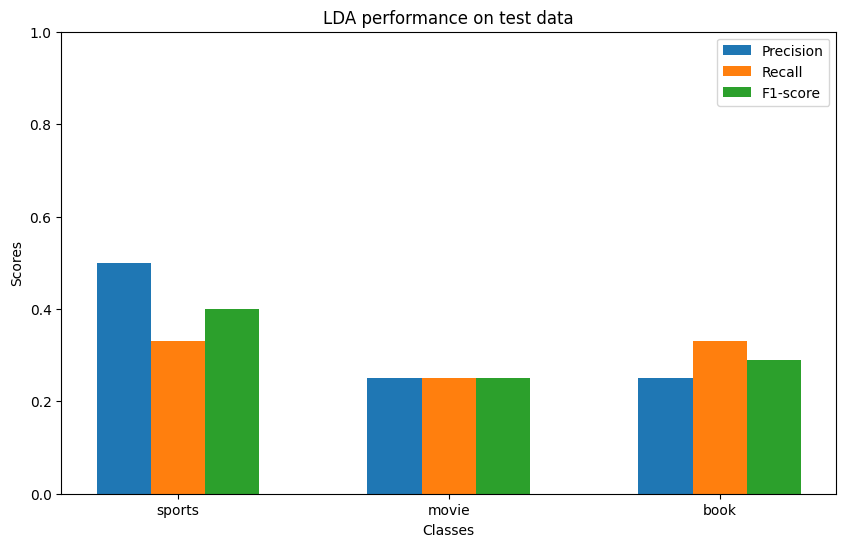

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels and corresponding scores
labels = ['sports', 'movie', 'book']
precision = [0.5, 0.25, 0.25]  # Example precision scores for each class
recall = [0.33, 0.25, 0.33]    # Example recall scores for each class
f1_score = [0.40, 0.25, 0.29]  # Example F1-scores for each class

# Plot bar graph
x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-score')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('LDA performance on test data')
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]
plt.show()